# Preparations

In [1]:
import torch 
import sklearn

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas import DataFrame

from collections import Counter
from tqdm import tqdm 
from data_utils import News20Data
from transformers import BertModel, BertTokenizer
from nltk.corpus import stopwords

from matplotlib.pyplot import figure
from matplotlib import collections as mc
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad

In [2]:
ckpt_path = '../models/bertnet_0.0.4.10.4/ckpt-e16.ptmodel.pt'
ckpt = torch.load(ckpt_path)
state_matrix = ckpt['state_matrix']

In [3]:
def read_state_freq(path):
    state_freq = np.zeros(2000)
    state_nonstop_freq = np.zeros(2000)
    with open(path) as fd:
        lines = fd.readlines()
        for li, l in enumerate(lines):
            if(li % 3 == 0):
                l = l.split()
                state_id = int(l[1])
                state_freq[state_id] = int(l[3])
                state_nonstop_freq[state_id] = int(l[5])
                
    state_freq_norm = np.log(state_freq)
    state_freq_norm = state_freq_norm - state_freq_norm.min()
    state_freq_norm = state_freq_norm / state_freq_norm.max()
    
    state_nonstop_freq_r = state_nonstop_freq / state_freq
    state_freq_idx_sort = state_freq.argsort()[::-1]
    state_freq_idx_inverse = {}
    for i, j in enumerate(state_freq_idx_sort):
        state_freq_idx_inverse[j] = i
    state_stop_freq = state_freq - state_nonstop_freq
    return state_freq_norm, state_nonstop_freq_r, state_freq_idx_sort, state_freq_idx_inverse, state_freq, state_nonstop_freq

In [4]:
state_freq_norm, state_nonstop_freq_r, state_freq_idx_sort, state_freq_idx_inverse, state_freq, state_nonstop_freq = read_state_freq(
    '/home/s1946695/Scale-CRF-Latent-Space/outputs/bertnet_0.0.4.10.4/bertnet_dev_epoch_16_s2w.txt')
state_id_sorted_to_origin = state_freq_idx_sort
state_id_origin_to_sorted = state_freq_idx_inverse

In [5]:
def read_state_bigram(path):
    bigrams = []
    with open(path) as fd:
        lines = fd.readlines()
        for l in lines:
            if(l.startswith('state')):
                from_state, to_state = map(int, l.split()[2].split('-'))
                freq = int(l.split()[4])
                bigrams.append([from_state, to_state, freq])
    freq_norm = np.log(np.array([b[2] for b in bigrams]))
    freq_norm = freq_norm - freq_norm.mean()
    freq_norm = freq_norm - freq_norm.min()
    freq_norm /= freq_norm.max()
    for bi, fn in zip(bigrams, freq_norm):
        bi.append(fn)
    return bigrams

In [6]:
state_bigrams = read_state_bigram('/home/s1946695/Scale-CRF-Latent-Space/outputs/bertnet_0.0.4.10.4/bertnet_dev_epoch_16_state_2gram_no_sw.txt')

In [7]:
k = 5
with torch.no_grad():
    sim_state_state = torch.matmul(state_matrix, state_matrix.transpose(0, 1))
    link_values, state_links = sim_state_state.topk(dim=-1, k=k)
    
state_bigram_dot_prod = []
state_links = state_links.cpu().numpy()
link_values = link_values.cpu().numpy()
for i, sl in enumerate(state_links):
    for j in range(k):
        state_bigram_dot_prod.append([i, sl[j], link_values[i, j]])
    
sim_bigram_norm = np.array([bi[-1] for bi in state_bigram_dot_prod])
sim_bigram_norm = np.log(sim_bigram_norm - sim_bigram_norm.min() + 1)
sim_bigram_norm = sim_bigram_norm / sim_bigram_norm.max()
for bi, sb in zip(state_bigram_dot_prod, sim_bigram_norm):
    bi[-1] = sb

In [8]:
in_top_500 = []
not_in_top_500 = []
for si, sj, _ in state_bigram_dot_prod:
    if(state_id_origin_to_sorted[si] < 500 or state_id_origin_to_sorted[sj] < 500): in_top_500.append((si, sj))
    else: not_in_top_500.append((si, sj))
print(len(in_top_500), len(not_in_top_500))

9973 27


In [9]:
in_top_500 = []
not_in_top_500 = []
for si, sj, _, _ in state_bigrams:
    if(state_id_origin_to_sorted[si] < 500 or state_id_origin_to_sorted[sj] < 500): in_top_500.append((si, sj))
    else: not_in_top_500.append((si, sj))
print(len(in_top_500), len(not_in_top_500))

2000 0


## tSNE

In [61]:
def metric_fn(x1, x2):
    """Hard set metrics between states to be large"""
    m = np.exp(-(x1 * x2).sum())
    return m

def tsne_preparation(queried_links, excluded_nodes, from_k, to_k, state_id_sorted_to_origin, state_id_origin_to_sorted):
    state_id_transformed_to_origin = list(state_id_sorted_to_origin[from_k: to_k])
    if(len(queried_links) > 0):
        added_queried_states = []
        for i, j in queried_links:
            i_ = state_id_origin_to_sorted[i]
            j_ = state_id_origin_to_sorted[j]
            if(i_ < from_k or i_ >= to_k): 
                print('Original state %d rank %d add to transformed list' % (i, i_))
                added_queried_states.append(i)
            if(j_ < from_k or j_ >= to_k): 
                print('Original state %d rank %d add to transformed list' % (j, j_))
                added_queried_states.append(j)

        for i, j in enumerate(added_queried_states):
            state_id_transformed_to_origin.append(j)
            
    state_id_transformed_to_origin = [i for i in state_id_transformed_to_origin if i not in excluded_nodes]
    state_id_origin_to_transformed = {}
    for trans, origin in enumerate(state_id_transformed_to_origin):
        state_id_origin_to_transformed[origin] = trans
    
    return state_id_transformed_to_origin, state_id_origin_to_transformed

def tsne_transform(state_matrix, state_id_transformed_to_origin, perplexity, n_iter, metric_fn=None):
    """Do tsne"""
    embeddings_vis = state_matrix.cpu().numpy()[state_id_transformed_to_origin]

    tsne = TSNE(n_components=2, verbose=2, perplexity=perplexity, n_iter=n_iter, metric=metric_fn)
    emb_transform = tsne.fit_transform(embeddings_vis)
    return emb_transform

def get_state_bigrams(state_matrix, state_id_transformed_to_origin, included_topk_near=20, remove_topk_node=10, sample_topk_ratio=0.01):
    state_matrix = state_matrix.cpu().numpy()
    state_matrix = state_matrix[state_id_transformed_to_origin]
    sim_state_state = np.matmul(state_matrix, np.transpose(state_matrix, [1, 0]))
    
    topk_connected = []
    
    state_bigrams = []
    for si, sim in enumerate(sim_state_state):
        sim_sort = np.argsort(sim)[::-1]
        for j in range(included_topk_near):
            sj = sim_sort[j]
            state_bigrams.append([si, sj, sim_state_state[si, sj]])
            topk_connected.append(sj)    
    topk_connected = Counter(topk_connected)
    removed = [si for si, _ in topk_connected.most_common(remove_topk_node)]
    
    state_bigrams_ = []
    sampled_strong = 0
    rejected_strong = 0
    for si, sj, wij in state_bigrams:
        if(si in removed or sj in removed): 
            if(np.random.uniform() < sample_topk_ratio):
                sampled_strong += 1
                state_bigrams_.append([si, sj, wij])
            else:
                rejected_strong += 1
                continue
        else: state_bigrams_.append([si, sj, wij])
    state_bigrams = state_bigrams_
            
    sim_bigram_norm = np.array([bi[-1] for bi in state_bigrams])
    sim_bigram_norm = np.log(sim_bigram_norm - sim_bigram_norm.min() + 1.1)
    sim_bigram_norm = sim_bigram_norm / sim_bigram_norm.max()
    for bi, sb in zip(state_bigrams, sim_bigram_norm): bi[-1] = sb
    return state_bigrams, topk_connected, removed, sampled_strong, rejected_strong

def tsne_transform_w_query(state_matrix, queried_links, state_id_sorted_to_origin, state_id_origin_to_sorted, perplexity, n_iter, from_k, to_k, metric_fn=None):
    """Do tsne"""
    state_id_transformed_to_origin = list(state_id_sorted_to_origin[from_k: to_k])
    state_id_origin_to_transformed = {}
    for trans, origin in enumerate(state_id_transformed_to_origin):
        state_id_origin_to_transformed[origin] = trans
    
    if(len(queried_links) > 0):
        added_queried_states = []
        for i, j in queried_links:
            i_ = state_id_origin_to_sorted[i]
            j_ = state_id_origin_to_sorted[j]
            if(i_ < from_k or i_ >= to_k): 
                print('Original state %d rank %d add to transformed list' % (i, i_))
                added_queried_states.append(i)
            if(j_ < from_k or j_ >= to_k): 
                print('Original state %d rank %d add to transformed list' % (j, j_))
                added_queried_states.append(j)

        for i, j in enumerate(added_queried_states):
            state_id_transformed_to_origin.append(j)
            state_id_origin_to_transformed[j] = len(state_id_transformed_to_origin) + i
    
    embeddings_vis = state_matrix.cpu().numpy()[state_id_transformed_to_origin]

    tsne = TSNE(n_components=2, verbose=2, perplexity=perplexity, n_iter=n_iter, metric=metric_fn)
    emb_transform = tsne.fit_transform(embeddings_vis)
    return emb_transform, state_id_transformed_to_origin, state_id_origin_to_transformed

## Plot

In [327]:
def drawCirc(ax,radius,centX,centY,angle_,theta2_,lw,color_='black'):
    #========Line
    arc = Arc([centX,centY],radius,radius,angle=angle_,
          theta1=0,theta2=theta2_,capstyle='round',linestyle='-.',lw=lw, color=color_, zorder=4)
    ax.add_patch(arc)


    #========Create the arrow head
    endX=centX+(radius/2)*np.cos(rad(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(rad(theta2_+angle_))

    ax.add_patch(                    #Create triangle as arrow head
        RegularPolygon(
            (endX, endY),            # (x,y)
            3,                       # number of vertices
            radius/9,                # radius
            rad(angle_+theta2_),     # orientation
            color=color_,
            zorder=4
        )
    )
    return 

def tsne_vis_state(emb_transform, state_bigram_transformed, state_nonstop_freq_r, state_freq_norm, n_edge, 
                   queried_links=None, state_id_origin_to_transformed=None, from_k=0, to_k=2000,
                   line_alpha=1., state_alpha=1., draw_lines=True, left_colorbar=True, right_colorbar=True, radius=20,
                   linewidth=0.6, state_power_rate=2,
                   edge_power_rate_0=0.3, edge_power_rate_1=1.3,
                   state_size_base=0.05, self_loop_offset=1):
    """Visualize the states"""
    print(len(emb_transform))
    print(len(state_bigram_transformed))
    
    sns.set(rc={'figure.figsize':(8,4), 'figure.dpi': 200})
    plt.rcParams["font.size"] = 3

    fig, ax = plt.subplots(1, 1, constrained_layout=True)
    
    ## Lines
    colors = [[255 / 255., 252 / 255.5, 133 / 255.], # yellow 
              [255 / 255., 252 / 255.5, 138 / 255.], # yellow
              [199 / 255., 255 / 255.5, 185 / 255.], # green 
              [0 / 255., 85 / 255.5, 255 / 255.],
              [0 / 255., 60 / 255.5, 179 / 255.]]
#     colors = [[235 / 255., 93 / 255.5, 36 / 255.], # yellow 
#               [246 / 255., 152 / 255.5, 25 / 255.], # yellow
#               [199 / 255., 255 / 255.5, 185 / 255.], # green 
#               [0 / 255., 85 / 255.5, 255 / 255.],
#               [0 / 255., 60 / 255.5, 179 / 255.]]
    cmap = LinearSegmentedColormap.from_list('colormap', colors, N=100)
#     cmap = mpl.cm.get_cmap('coolwarm')
#     cmap = mpl.cm.get_cmap('RdBu')
#     cmap = mpl.cm.get_cmap('RdYlBu')
    line_strength = []
    lines = []
    lines_out = []
    queried_lines = []
    
    if(draw_lines):
        for bi in state_bigram_transformed:
            i = bi[0]
            j = bi[1]
            lines_out.append(bi)
            a = bi[-1]
            if(i == j): continue
            if(i < from_k or i >= to_k): continue
            if(j < from_k or j >= to_k): continue

            x1 = emb_transform[i, 0]
            x2 = emb_transform[j, 0]
            y1 = emb_transform[i, 1]
            y2 = emb_transform[j, 1]
            lines.append([(x1, y1), (x2, y2)])
            line_strength.append(a)
            
        line_strength = np.array(line_strength)
        line_strength[np.where(line_strength < 0.5)] = np.power(line_strength[np.where(line_strength < 0.5)], edge_power_rate_0)
        line_strength[np.where(line_strength > 0.5)] = np.power(line_strength[np.where(line_strength > 0.5)], edge_power_rate_1)
        
#         line_strength = np.power(line_strength, edge_power_rate)
        line_colors = cmap(line_strength)
        if(queried_links is not None): line_alpha_ = 0.1
        else: line_alpha_ = line_alpha
        lines = mc.LineCollection(lines, linewidths=linewidth, colors=line_colors, alpha=line_alpha_, linestyle='-.', zorder=2.5)
        pcm = ax.add_collection(lines)
    if(left_colorbar):
        cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), location='left', ticks=[0.3, 0.7], shrink=0.8)
        cbar.ax.set_yticklabels(['Weaker transition', 'Stronger transition'], fontsize=15, rotation=270, verticalalignment='center') 

    ## States
    if(queried_links is not None): state_alpha_ = 0.1
    else: state_alpha_ = state_alpha
    plot = ax.scatter(x=emb_transform[:, 0], y=emb_transform[:, 1], 
                      c=np.power(state_nonstop_freq_r, state_power_rate), 
                      cmap='Blues', edgecolors='tab:grey', 
                      s=state_size_base * np.exp(state_freq_norm), linewidths=0.3, alpha=state_alpha_, zorder=3)
    if(right_colorbar):
        cbar = fig.colorbar(plot, ticks=[0.2, 0.5, 0.8], shrink=0.8)
        cbar.ax.set_yticklabels(['Static', 'Intermediate', 'Contextualized'], verticalalignment='center', rotation=270, fontsize=15) 
    
    ## Queries
    if(queried_links is not None):
        queried_lines = []
        queried_states = []
        self_states_loc = []
        for i, j in queried_links:
            i_ = state_id_origin_to_transformed[i]
            j_ = state_id_origin_to_transformed[j]
            queried_states.append(i_)
            queried_states.append(j_)
            
            if(i != j):
                x1 = emb_transform[i_, 0]
                x2 = emb_transform[j_, 0]
                y1 = emb_transform[i_, 1]
                y2 = emb_transform[j_, 1]
                queried_lines.append([(x1, y1), (x2, y2)])
            else:
                x = emb_transform[i_, 0] - self_loop_offset
                y = emb_transform[i_, 1]
                self_states_loc.append((x, y))
            
        # lines
        lines = mc.LineCollection(queried_lines, linewidths=linewidth, color='tab:orange', alpha=1, linestyle='-.', zorder=3)
        ax.add_collection(lines)
        
        # states
        queried_states = np.unique(np.array(queried_states))
        plot=ax.scatter(x=emb_transform[queried_states, 0], y=emb_transform[queried_states, 1], 
                        c=np.exp(state_nonstop_freq_r[queried_states]), 
                        cmap='Blues', edgecolors='tab:grey', 
                        s=80 * np.exp(state_freq_norm[queried_states]), linewidths=0.3, alpha=state_alpha, zorder=3)
        
        cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap='Blues'), location='right', ticks=[0.2, 0.5, 0.8], shrink=0.8)
        cbar.ax.set_yticklabels(['Static', 'Intermediate', 'Contextualized'], verticalalignment='center', rotation=270, fontsize=15)
    
        # self-looping states
        for x, y in self_states_loc:
            drawCirc(ax, radius, x, y, 0, 300, lw=linewidth, color_='tab:orange')
    plt.tick_params(axis='both', which='both', left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False) 
    return line_strength

# Visualization

## Transformation

In [329]:
queried_links = [(476, 243), (192, 1417), (1417, 1683), (1064, 476), (1572, 476), (254, 476)]
excluded_nodes = [828, 747, 714, 1320, 1701, 143, 735]
from_k = 500
to_k = 2000

state_id_transformed_to_origin, state_id_origin_to_transformed = tsne_preparation(
    queried_links, excluded_nodes, from_k, to_k, state_id_sorted_to_origin, state_id_origin_to_sorted)

Original state 476 rank 13 add to transformed list
Original state 243 rank 30 add to transformed list
Original state 192 rank 270 add to transformed list
Original state 1417 rank 87 add to transformed list
Original state 1417 rank 87 add to transformed list
Original state 1683 rank 62 add to transformed list
Original state 1064 rank 133 add to transformed list
Original state 476 rank 13 add to transformed list
Original state 1572 rank 45 add to transformed list
Original state 476 rank 13 add to transformed list
Original state 254 rank 14 add to transformed list
Original state 476 rank 13 add to transformed list


In [333]:
emb_transform = tsne_transform(state_matrix, state_id_transformed_to_origin, perplexity=5, n_iter=4000, metric_fn=metric_fn)

/home/s1946695/miniconda3/envs/_dl_py36_dev/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1505 samples in 0.002s...
[t-SNE] Computed neighbors for 1505 samples in 14.982s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1505
[t-SNE] Computed conditional probabilities for sample 1505 / 1505
[t-SNE] Mean sigma: 0.026768
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 168.4109192, gradient norm = 0.1792030 (50 iterations in 1.050s)
[t-SNE] Iteration 100: error = 167.0317230, gradient norm = 0.3296305 (50 iterations in 1.300s)
[t-SNE] Iteration 150: error = 188.1571350, gradient norm = 0.1868106 (50 iterations in 0.934s)
[t-SNE] Iteration 200: error = 185.4454193, gradient norm = 0.2102766 (50 iterations in 1.210s)
[t-SNE] Iteration 250: error = 158.1256866, gradient norm = 0.3546932 (50 iterations in 1.059s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 158.125687
[t-SNE] Iteration 300: error = 6.9803720, gradient norm = 0.0063039 (50 iterations in 

## Visualization

In [208]:
state_bigrams_transformed, topk_connected, state_removed, sampled_strong, rejected_strong =\
    get_state_bigrams(state_matrix, state_id_transformed_to_origin, included_topk_near=30, remove_topk_node=50, sample_topk_ratio=0.01)
print(len(state_bigrams_transformed), sampled_strong, rejected_strong)

1089 457 43941


In [192]:
line_strength.mean(), line_strength.min(), line_strength.max()

(0.5078933, 0.17772287, 0.896734)

1505
1089


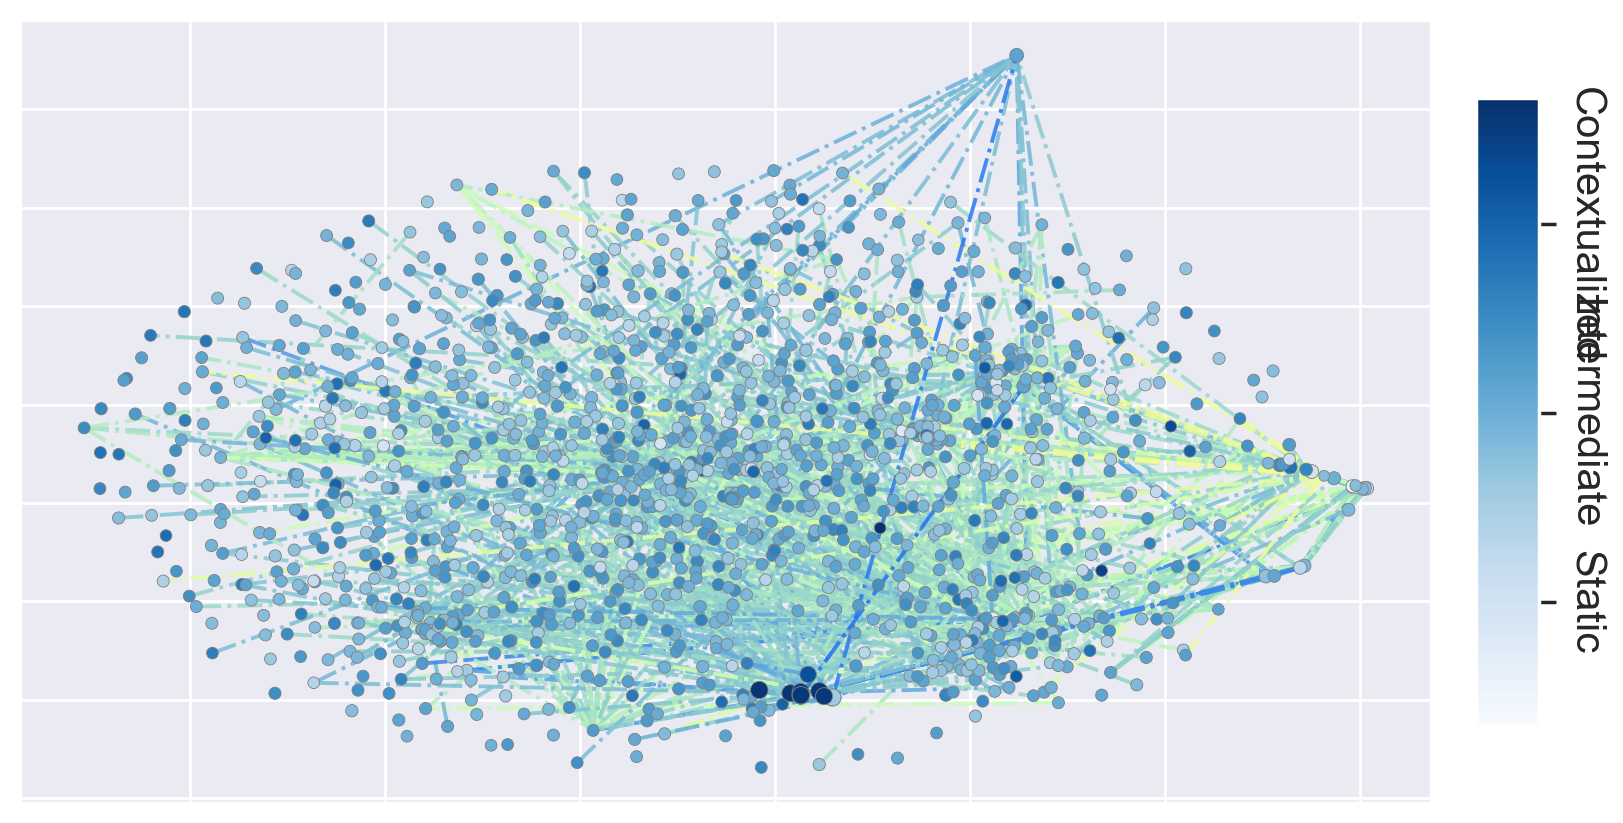

In [334]:
state_nonstop_freq_r_ = state_nonstop_freq_r[state_id_transformed_to_origin]
state_freq_norm_ = state_freq_norm[state_id_transformed_to_origin]
line_strength = tsne_vis_state(emb_transform, state_bigrams_transformed, state_nonstop_freq_r_, state_freq_norm_, 
                           state_id_origin_to_transformed=state_id_origin_to_transformed,
                           linewidth=1.4, state_power_rate=1.2,
                           edge_power_rate_0=0.32, edge_power_rate_1=1.2,
                           n_edge=10000, line_alpha=0.85, state_alpha=1, draw_lines=True, left_colorbar=False, right_colorbar=True,
                           radius=1, state_size_base=15, self_loop_offset=0.5
                          )

1505
1089


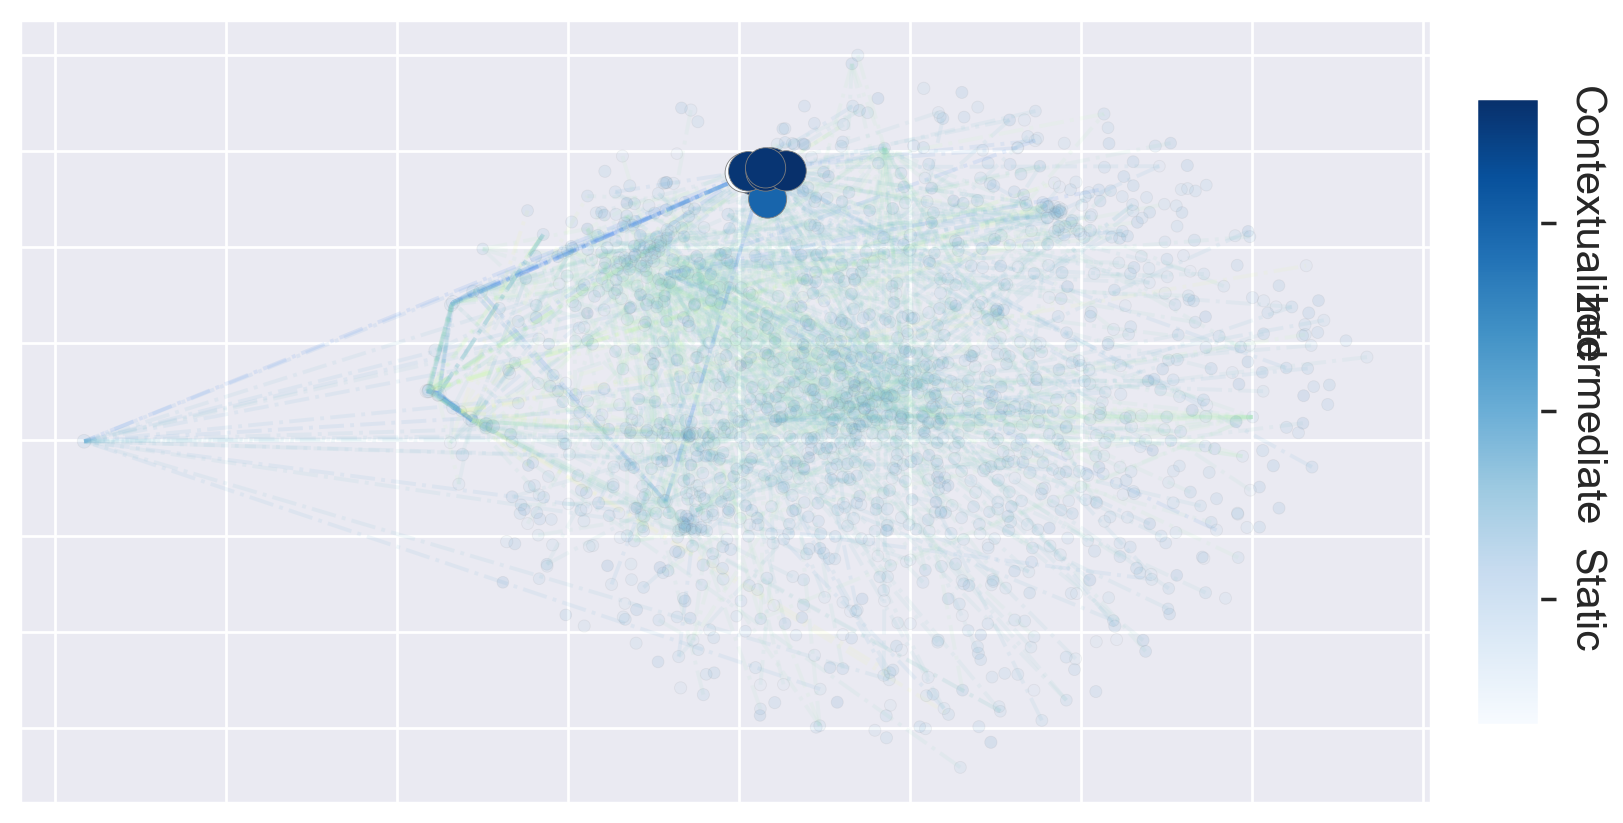

In [332]:
state_nonstop_freq_r_ = state_nonstop_freq_r[state_id_transformed_to_origin]
state_freq_norm_ = state_freq_norm[state_id_transformed_to_origin]
line_strength = tsne_vis_state(emb_transform, state_bigrams_transformed, state_nonstop_freq_r_, state_freq_norm_, 
                               queried_links=queried_links,
                               state_id_origin_to_transformed=state_id_origin_to_transformed,
                               linewidth=1.4, state_power_rate=1.2,
                               edge_power_rate_0=0.32, edge_power_rate_1=1.2,
                               n_edge=10000, line_alpha=0.85, state_alpha=1, draw_lines=True, left_colorbar=False, right_colorbar=False,
                               radius=0.8, state_size_base=15, self_loop_offset=0.5
                              )

In [173]:
len(state_bigram_transformed)

15010

In [163]:
state_bigrams_transformed, topk_connected, state_removed = get_state_bigrams(state_matrix, state_id_transformed_to_origin, remove_topk=11)

In [164]:
len(state_bigrams_transformed)

169

15010


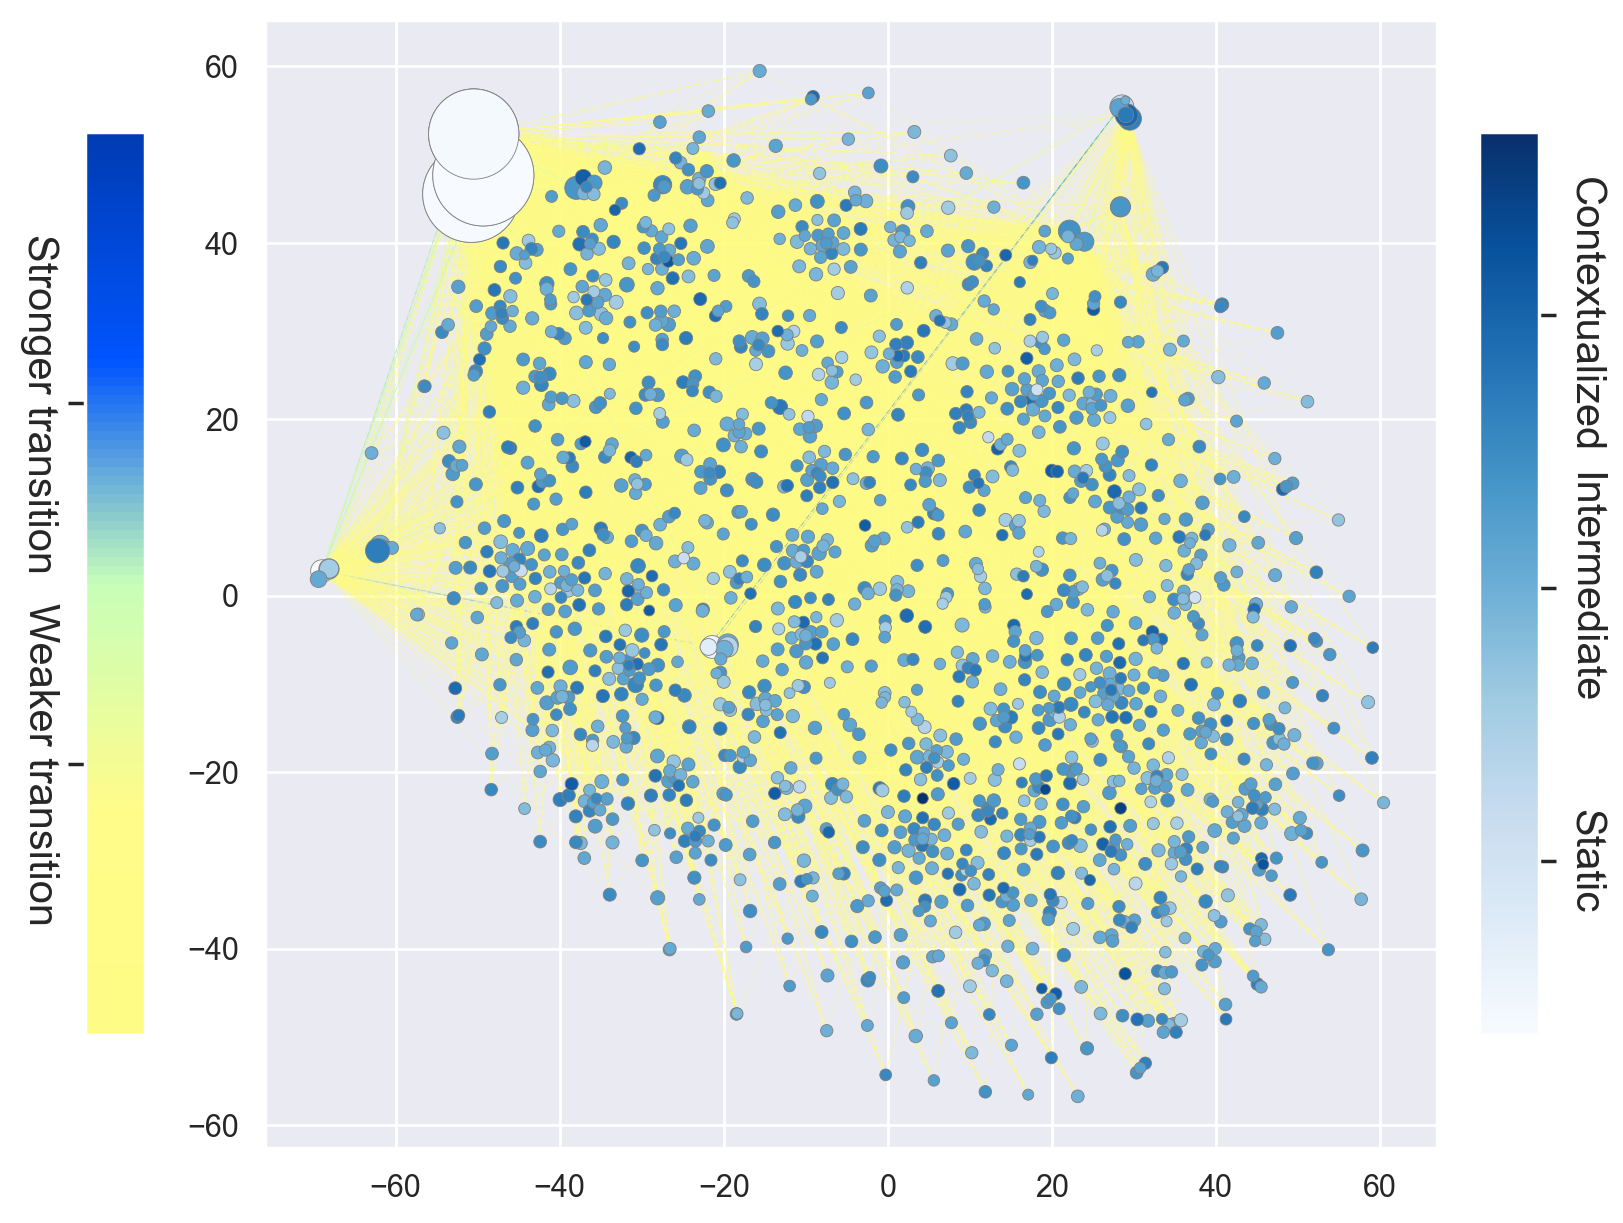

In [165]:
state_nonstop_freq_r_ = state_nonstop_freq_r[state_id_transformed_to_origin]
state_freq_norm_ = state_freq_norm[state_id_transformed_to_origin]
lines_out = tsne_vis_state(emb_transform, state_bigram_transformed, state_id_origin_to_transformed, state_nonstop_freq_r_, state_freq_norm_, 
                   state_id_origin_to_transformed=state_id_origin_to_transformed,
                   n_edge=10000, line_alpha=0.5, state_alpha=1., draw_lines=True, left_colorbar=True, right_colorbar=True,
                   radius=6, state_size_base=0.5
                  )

In [161]:
len(lines_out)

15010

In [89]:
[state_id_transformed_to_origin[i] for i in np.where(emb_transform[:, 0] < -60)[0]]

[828, 747, 714]

In [91]:
[state_id_transformed_to_origin[i] for i in np.where(emb_transform[:, 1] < -80)[0]]

[828, 1320, 1701, 143, 735]